In [1]:
# Load the Julia environment needed for this notebook
import Pkg
Pkg.activate("../../Tasks2D")

  Activating project at `~/Developer/research/fall2023/cocosci/tasks2D/Tasks2D`


In [2]:
import Makie   # Visualization Library
using Revise      # For development; makes it so modifications
                  # to imported modules are immediately reflected in this Julia session
using Gen         # Gen probabilistic programming library
import GenParticleFilters # Additional particle filtering functionality for Gen
import GridWorlds # Simple gridworld functionality
import LineWorlds
const L = LineWorlds
import LineWorlds: cast # Ray caster
import GenPOMDPs  # Beginnings of a Gen POMDP library

import Tasks2D
import LinearAlgebra
import Dates

Precompiling Tasks2D
  ✓ CairoMakie
  ✓ WGLMakie
  ✓ Tasks2D
  3 dependencies successfully precompiled in 23 seconds. 395 already precompiled.


In [3]:
includet("src/Utils.jl")
includet("src/VizUtils.jl")

In [4]:
import GLMakie
GLMakie.activate!()

# Construct model, etc

In [5]:
# Initial position model

# Distribution to sample uniformly from a Julia Set
using Tasks2D.Distributions: uniform_from_set

@gen (static) function uniform_agent_pos(params)
    w = params.map # a map, represented as a GridWorlds.GridWorld
    
    cell ~ uniform_from_set(GridWorlds.empty_cells(w))
    
    # Cell (i, j) corresponds to the region from i-1 to i and j-1 to j
    x ~ uniform(cell[1] - 1, cell[1])
    y ~ uniform(cell[2] - 1, cell[2])
    
    return ([x, y], 0, false)
end

var"##StaticGenFunction_uniform_agent_pos#251"(Dict{Symbol, Any}(), Dict{Symbol, Any}())

In [6]:
function pos_to_init_cm(pos)
    (x, y) = pos
    i = Int(ceil(x))
    j = Int(ceil(y))
    return choicemap(
        (:cell, (i, j)),
        (:x, x),
        (:y, y)
    )
end
function state_to_pos(state)
    return state[1]
end

state_to_pos (generic function with 1 method)

In [7]:
function det_next_pos(pos, a, Δ)
    (x, y) = pos
    a == :up    ? [x, y + Δ] :
    a == :down  ? [x, y - Δ] : 
    a == :left  ? [x - Δ, y] :
    a == :right ? [x + Δ, y] :
    a == :stay  ? [x, y]     :
                error("Unrecognized action: $a")
end

function handle_wall_intersection(prev, new, gridworld)
    walls = GridWorlds.nonempty_segments(gridworld)
    move = L.Segment(prev, new)
    
    min_collision_dist = Inf
    vec_to_min_dist_collision = nothing
    for i in 1:(size(walls)[1])
        wall = walls[i, :]
        # print("wall: $wall")
        do_intersect, dist = L.Geometry.cast(move, L.Segment(wall))

        if do_intersect && dist ≤ L.Geometry.norm(move)
            if dist < min_collision_dist
                min_collision_dist = dist
                vec_to_min_dist_collision = L.Geometry.diff(move)
            end
        end
    end
    
    if !isnothing(vec_to_min_dist_collision)
        dist = min_collision_dist
        if dist < 0.05
            return (prev, true)
        else
            normalized_vec = (vec_to_min_dist_collision / L.Geometry.norm(vec_to_min_dist_collision))
            collision_pt = prev + (dist - 0.04) * normalized_vec
            return (collision_pt, true)
        end
    end
    
    return (new, false)
end

handle_wall_intersection (generic function with 1 method)

In [8]:
@gen (static) function motion_model(state, action, params)
    (a, wall_clock_time) = action
    (pos, t_prev, prev_hit_wall) = state
    w, σ = params.map, params.step.σ
    
    next_pos_det = det_next_pos(pos, a, params.step.Δ)
    noisy_next_pos ~ broadcasted_normal(next_pos_det, params.step.σ)
    (next_pos, hit_wall) = handle_wall_intersection(pos, noisy_next_pos, w)
    
    return (next_pos, t_prev + 1, prev_hit_wall || hit_wall)
end
pos_to_step_cm(pos) = choicemap(
    (:noisy_next_pos, pos)
)
function nonoise_nextpos(pos, action, Δ, gridworld)
    (a, _) = action
    newpos = det_next_pos(pos, a, Δ)
    final_pos, did_collide = handle_wall_intersection(pos, newpos, gridworld)
    return final_pos
end

nonoise_nextpos (generic function with 1 method)

In [9]:
@gen function observe_noisy_distances(state, params)
    (pos, t, _) = state

    p = reshape([pos..., params.obs.orientation], (1, 3))
    _as = L.create_angles(params.obs.fov, params.obs.n_rays)
    wall_segs = GridWorlds.wall_segments(params.map)
    strange_segs = GridWorlds.strange_segments(params.map)
    @assert isempty(strange_segs) "Strange objects not supported in this model variant"
    
    w, s_noise, outlier, outlier_vol, zmax = params.obs.wall_sensor_args
    dists_walls = L.cast(p, wall_segs; num_a=params.obs.n_rays, zmax)
    dists_walls = reshape(dists_walls, (:,))

    wall_measurements = dists_walls
    obs ~ Gen.broadcasted_normal(wall_measurements, s_noise)

    return obs
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##observe_noisy_distances#296", Bool[0, 0], false)

In [10]:
# POMDP of this environment
pomdp = GenPOMDPs.GenPOMDP(
    uniform_agent_pos,       # INIT   : params                      ⇝ state
    motion_model,            # STEP   : prev_state, actions, params ⇝ state
    observe_noisy_distances, # OBS    : state, params               ⇝ observation
    (state, action) -> 0.    # UTILITY: state, action, params       → utility
)

GenPOMDPs.GenPOMDP(var"##StaticGenFunction_uniform_agent_pos#251"(Dict{Symbol, Any}(), Dict{Symbol, Any}()), var"##StaticGenFunction_motion_model#288"(Dict{Symbol, Any}(), Dict{Symbol, Any}()), DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##observe_noisy_distances#296", Bool[0, 0], false), var"#57#58"())

In [11]:
# Generative function over trajectories of the POMDP,
# given a fixed action sequence.
trajectory_model = GenPOMDPs.ControlledTrajectoryModel(pomdp)

GenPOMDPs.var"##StaticGenFunction__ControlledTrajectoryModel#368"(Dict{Symbol, Any}(), Dict{Symbol, Any}())

In [12]:
_get_params(map) = (;
    # map = GridWorlds.load_custom_map(5),
    map=map,
    step = (; Δ = .5, σ = 0.4),
    obs = (; fov = 2π, n_rays = 90, orientation = π/2,
        # I think currently only σ is used
        wall_sensor_args = (;
            w = 5, s_noise = 0.02,
            outlier = 0.0001,
            outlier_vol = 100.0,
            zmax = 100.0, σ=0.005
        )
    )
)

MAPSTR = """
wwwwwwwwwwwwwwwww
w               w
w        w      w
w        w      w
w        w      w
w        w      w
w               w
w               w
w               w
wwwwwwwwwwwwwwwww
"""
params = _get_params(GridWorlds.mapstr_to_gridworld(MAPSTR));

## Action controllers & rollout models for simulation

In [13]:
@gen function _random_controller(st, obs)
    aidx ~ categorical([0.25, 0.25, 0.25, 0.25])
    action = [:up, :right, :left, :down][aidx]
    return ((action, Dates.now()), nothing)
end
random_controller = GenPOMDPs.Controller(_random_controller, nothing)
random_agent_model = GenPOMDPs.RolloutModel(pomdp, random_controller);

In [14]:
@gen function _meandering_controller(current_direction, obs)
    change_dir ~ bernoulli(0.2)
    if change_dir || isnothing(current_direction)
        aidx ~ categorical([0.25, 0.25, 0.25, 0.25])
        action = [:up, :right, :left, :down][aidx]
    else
        action = current_direction
    end
    return ((action, Dates.now()), action)
end
meandering_controller = GenPOMDPs.Controller(_meandering_controller, nothing)
meandering_agent_model = GenPOMDPs.RolloutModel(pomdp, meandering_controller);

In [15]:
@gen function _meandering_wallavoiding_controller(current_direction, obs)
    # d, r, u, l
    directional_dist_inds = [Int(floor(i)) for i in LinRange(1, length(obs) + 1, 5)[1:4]]
    relevant_dists = obs[directional_dist_inds]
    near_walls = Dict()
    near_walls[:down] = relevant_dists[1] < 1
    near_walls[:right] = relevant_dists[2] < 1
    near_walls[:up] = relevant_dists[3] < 1
    near_walls[:left] = relevant_dists[4] < 1

    if near_walls[:down]
        action = :up
    elseif near_walls[:right]
        action = :left
    elseif near_walls[:up]
        action = :down
    elseif near_walls[:left]
        action = :right
    else
        action = nothing
    end

    if isnothing(action)
        change_dir ~ bernoulli(0.2)
        if change_dir || isnothing(current_direction)
            aidx ~ categorical([0.25, 0.25, 0.25, 0.25])
            action = [:up, :right, :left, :down][aidx]
        else
            action = current_direction
        end
    end

    i = 0
    while near_walls[action]
        # println("near_walls[$action]")
        if i > 20
            break
        end
        i += 1
        aidx = {(:aidx, i)} ~ categorical([0.25, 0.25, 0.25, 0.25])
        action = [:up, :right, :left, :down][aidx]
    end
    # println("near walls: $(near_walls[action])")

    return ((action, Dates.now()), action)
end
meandering_wallavoiding_controller = GenPOMDPs.Controller(_meandering_wallavoiding_controller, nothing)
meandering_wallavoiding_agent_model = GenPOMDPs.RolloutModel(pomdp, meandering_wallavoiding_controller);

## Inference

In [16]:
includet("src/inference.jl")

In [17]:
function make_bpf(params, n_particles)
    (t0_grid_args, update_grid_args, _) = default_pf_args(params, coarsest_stepsize=0.2)
    return GenPOMDPs.pf(
        pomdp, params,
        obs -> (
            n_particles,
            GenSMCP3.SMCP3Update(
                fwd_iterated_grid, bwd_iterated_grid,
                (true, trajectory_model, params, obs, t0_grid_args, pos_to_init_cm, state_to_pos, nothing, nonoise_nextpos),
                (true, t0_grid_args, state_to_pos, nonoise_nextpos)
            )
        ),
        (action, obs) -> (), # bootstrap update,
        pre_update = GenPOMDPs.stratified_resample_if_ess_below_one_plus_onetenth_particlecount
    )
end
function make_c2f_pf(params, n_particles, sigma_multiplier; coarsest_stepsize=0.2)
    (t0_grid_args, update_grid_args, _) = default_pf_args(params; sigma_multiplier, coarsest_stepsize)

    return GenPOMDPs.pf(
        pomdp, params,
        obs -> (
            n_particles,
            GenSMCP3.SMCP3Update(
                fwd_iterated_grid, bwd_iterated_grid,
                (
                    true, trajectory_model, params, obs, t0_grid_args,
                    pos_to_init_cm, state_to_pos, nothing, nonoise_nextpos
                ),
                (true, t0_grid_args, state_to_pos, nonoise_nextpos)
            )
        ),
        (action, obs) -> (
            SMCP3Update(
                fwd_iterated_grid, bwd_iterated_grid,
                (
                    false, trajectory_model, params, obs, update_grid_args,
                    pos_to_step_cm, state_to_pos, action, nonoise_nextpos
                ),
                (false, update_grid_args, state_to_pos, nonoise_nextpos)
            
            ),
        ),
        pre_update = GenPOMDPs.stratified_resample_if_ess_below_one_plus_onetenth_particlecount
    );
end

function make_pf(params, spec)
    """
    Accepts a spec of one of the following forms:
    - (; type=:bootstrap, n_particles)
    - (; type=:c2f, n_particles, sigma_multiplier [, coarsest_stepsize])
    """
    if spec.type == :bootstrap
        return make_bpf(params, spec.n_particles)
    else
        if haskey(spec, :coarsest_stepsize)
            return make_c2f_pf(params, spec.n_particles, spec.sigma_multiplier, coarsest_stepsize=spec.coarsest_stepsize)
        else
            return make_c2f_pf(params, spec.n_particles, spec.sigma_multiplier)
        end
    end
end

make_pf (generic function with 1 method)

### Measure the accuracy of inference as the number of steps close to the ground truth:

In [18]:
"""
Number of timesteps at which the current average error in the position is > eps.
(Avg error in position defined w.r.t. the particle posterior approximation.)
"""
function eval_accuracy(gt_tr, pf_states; eps = 0.3)
    total_error = 0.
    for t in 1:get_args(gt_tr)[1]
        gt_pos = GenPOMDPs.state_sequence(gt_tr)[t][1]
        pf_positions = [
            GenPOMDPs.state_sequence(trace)[t][1]
            for trace in get_traces(pf_states[t])
        ]
        pf_normalized_weights = GenParticleFilters.get_norm_weights(pf_states[t])
        avg_error = sum([
            pf_normalized_weights[i] * LinearAlgebra.norm(pf_positions[i] - gt_pos)
            for i in 1:length(pf_positions)
        ])
        total_error += (avg_error > eps ? 1 : 0)
    end
    return total_error
end

eval_accuracy

### Demo of catastrophic inference failure

In [19]:
GROUNDTRUTH_TRACE_FILENAMES = [
    # traces in a very simple env:
    "saves/2023-12-27T12:54:47.359__pomdp_trace.jld", # highly deterministic
    "saves/2023-12-28T11:49:09.674__pomdp_trace.jld", # moderate motion noise
    "saves/2023-12-28T11:58:38.916__pomdp_trace.jld", # high motion noise
]

3-element Vector{String}:
 "saves/2023-12-27T12:54:47.359__pomdp_trace.jld"
 "saves/2023-12-28T11:49:09.674__pomdp_trace.jld"
 "saves/2023-12-28T11:58:38.916__pomdp_trace.jld"

In [20]:
# world_trace, take_action = VizUtils.get_interactive_trace(
#     trajectory_model, params,
#     choicemap((GenPOMDPs.state_addr(0, :cell), (3, 3)))  
# );


In [21]:
# (f, t) = GridWorlds.Viz.interactive_2panel(
#     take_action,
#     Makie.@lift(get_args($world_trace)[3].map), # map
#     Makie.@lift([pos for (pos, _, _) in GenPOMDPs.state_sequence($world_trace)]),
#     Makie.@lift([
#         [pos for (pos, _, _) in GenPOMDPs.state_sequence(trace)]
#         for trace in get_traces($pf_states[end])
#     ]),
#     Makie.@lift(get_log_weights($pf_states[end])),
#     gt_obs=Makie.@lift(GenPOMDPs.observation_retval_sequence($world_trace)[end]),
#     particle_obss=Makie.@lift([
#         GenPOMDPs.observation_retval_sequence(trace)[end]
#         for trace in get_traces($pf_states[end])
#     ]),
#     close_on_hitwall=true,
#     did_hitwall_observable=VizUtils.get_did_hitwall_observable(world_trace),
#     save_fn = (() -> VizUtils.get_save_tr(world_trace)([1, 2, 3])),
# )
# display(f)

In [22]:
# A couple interesting saves:
# "saves/2023-12-29T14:34:46.219__pomdp_trace.jld"
# "saves/2023-12-29T14:35:18.502__pomdp_trace.jld"

In [23]:
save_fname = "saves/2023-12-29T16:09:18.223__pomdp_trace_and_pfstates.jld"
(_tr, _pfstates) = Utils.deserialize_trace_and_pf_states(
    save_fname,
    trajectory_model
);

# gif_filename = GridWorlds.Viz.pf_result_gif(
#     get_args(_tr)[3].map,
#     fr -> [pos for (pos, _, _) in GenPOMDPs.state_sequence(_tr)[1:fr]],
#     fr -> [
#         [pos for (pos, _, _) in GenPOMDPs.state_sequence(trace)]
#         for trace in get_traces(_pfstates[fr])
#     ],
#     fr -> get_log_weights(_pfstates[fr]);
#     fr_to_gt_obs = fr -> GenPOMDPs.observation_retval_sequence(_tr)[fr],
#     fr_to_particle_obss = fr -> [
#         GenPOMDPs.observation_retval_sequence(trace)[end]
#         for trace in get_traces(_pfstates[fr])
#     ],
#     framerate=4,
#     n_frames=length(_pfstates)-1,
#     n_panels=3,
#     tail_length=8,
#     labeltext="Inference via 10 particle bootstrap PF w/ C2F grid initialization. step.σ = $(get_args(_tr)[3].step.σ); near 0 obs noise;\nfname = $(save_fname)",
#     label_fontsize=16,
#     filename="01_bpf_inference_failure",
#     filetypes = ["gif", "mp4"],
    
# )
# println("File generated")
# display("image/gif", read(gif_filename))

### demo that BPF works ok at low motion noise

In [24]:
# uncomment this to generate a new trace

import Dates
function get_save_fn(tr, pf_states)
    function save_fn()
        filename = "saves/" * string(Dates.now()) * "__pomdp_trace_and_pfstates.jld"
        Utils.serialize_trace_and_pf_states(filename, tr[], pf_states[])
    end
    return save_fn
end

params_lownoise = _get_params(GridWorlds.mapstr_to_gridworld(MAPSTR));
params_lownoise = (; params_lownoise..., step = (; params_lownoise.step..., σ = 0.05))

world_trace, take_action = VizUtils.get_interactive_trace(
    trajectory_model, params_lownoise,
    choicemap((GenPOMDPs.state_addr(0, :cell), (3, 7)))  
);

bpf_pf = make_bpf(params_lownoise, 10)

obs_act_observable = Makie.@lift((
    GenPOMDPs.observation_sequence($world_trace),
    GenPOMDPs.action_sequence($world_trace)
))
pf_states = GenPOMDPs.pf_observable(bpf_pf, obs_act_observable);

(f, t) = GridWorlds.Viz.interactive_2panel(
    take_action,
    Makie.@lift(get_args($world_trace)[3].map), # map
    Makie.@lift([pos for (pos, _, _) in GenPOMDPs.state_sequence($world_trace)]),
    Makie.@lift([
        [pos for (pos, _, _) in GenPOMDPs.state_sequence(trace)]
        for trace in get_traces($pf_states[end])
    ]),
    Makie.@lift(get_log_weights($pf_states[end])),
    gt_obs=Makie.@lift(GenPOMDPs.observation_retval_sequence($world_trace)[end]),
    particle_obss=Makie.@lift([
        GenPOMDPs.observation_retval_sequence(trace)[end]
        for trace in get_traces($pf_states[end])
    ]),
    close_on_hitwall=true,
    did_hitwall_observable=VizUtils.get_did_hitwall_observable(world_trace),
    save_fn = get_save_fn(world_trace, pf_states),
)
display(f)

GLMakie.Screen(...)

Trace & pf states serialized to saves/2024-01-20T11:08:08.050__pomdp_trace_and_pfstates.jld.


In [25]:
# save_fname = "saves/2024-01-03T13:06:11.070__pomdp_trace_and_pfstates.jld"
save_fname = "saves/2024-01-20T11:08:08.050__pomdp_trace_and_pfstates.jld"
(_tr2, _pfstates2) = Utils.deserialize_trace_and_pf_states(
    save_fname,
    trajectory_model
);

# gif_filename = GridWorlds.Viz.pf_result_gif(
#     get_args(_tr2)[3].map,
#     fr -> [pos for (pos, _, _) in GenPOMDPs.state_sequence(_tr2)[1:fr]],
#     fr -> [
#         [pos for (pos, _, _) in GenPOMDPs.state_sequence(trace)]
#         for trace in get_traces(_pfstates2[fr])
#     ],
#     fr -> get_log_weights(_pfstates2[fr]);
#     fr_to_gt_obs = fr -> GenPOMDPs.observation_retval_sequence(_tr2)[fr],
#     fr_to_particle_obss = fr -> [
#         GenPOMDPs.observation_retval_sequence(trace)[end]
#         for trace in get_traces(_pfstates2[fr])
#     ],
#     framerate=4,
#     n_frames=length(_pfstates2)-1,
#     n_panels=3,
#     tail_length=8,
#     labeltext="Inference via 10 particle bootstrap PF w/ C2F grid initialization. step.σ = $(get_args(_tr)[3].step.σ); near 0 obs noise;\nfname = $(save_fname)",
#     label_fontsize=16,
#     filename="00_bpf_inference_success",
#     # filetypes = ["gif", "mp4"],
#     show_lines_to_walls=true
# )
# println("File generated")
# display("image/gif", read(gif_filename))

In [26]:
function log_obs_likelihood(t, pfstate)
    vals = [Gen.project(tr, select(GenPOMDPs.obs_addr(t))) for tr in pfstate.traces]
    weights = GenParticleFilters.get_norm_weights(pfstate)
    return sum(weights .* vals)
end
vals2 = [log_obs_likelihood(t - 1, pfstate) for (t, pfstate) in enumerate(_pfstates2)]
vals = [log_obs_likelihood(t - 1, pfstate) for (t, pfstate) in enumerate(_pfstates)]
concatenated = vcat(vals2, vals);

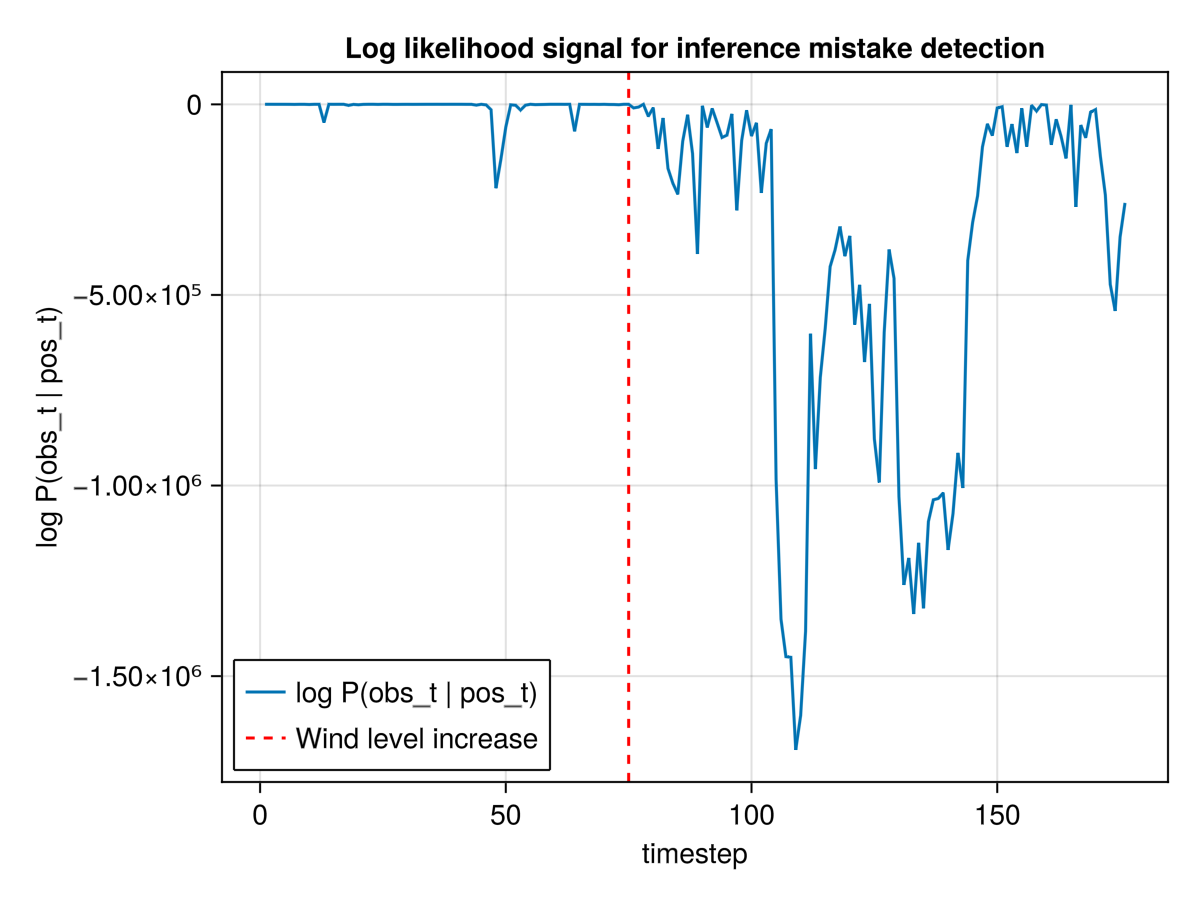

In [27]:
f = Makie.Figure(); ax = Makie.Axis(f[1, 1], xlabel="timestep", ylabel="log P(obs_t | pos_t)", title="Log likelihood signal for inference mistake detection")
Makie.lines!(ax, concatenated, label="log P(obs_t | pos_t)")
Makie.vlines!(ax, [length(vals2) + 1], label="Wind level increase", color=:red, linestyle=:dash)
# Makie.hlines!(ax, [threshold_1_in_10000], label="Mistake detection threshold", color=:orange)
Makie.axislegend(position=:lb)
f

## Inference controller

### Threshold calibration

In [28]:
# Generate data

n_steps_calibration = 100
n_calibration_trs = 1000
calibration_trs = [Gen.simulate(random_agent_model, (n_steps_calibration, params)) for _ in 1:n_calibration_trs];
obs_log_likelihoods = [
    Gen.project(tr, select(GenPOMDPs.obs_addr(step)))
    for tr in calibration_trs, step in 1:n_steps_calibration
];

In [29]:
get_percentile_threshold(percentile) = sort(collect(Iterators.flatten(obs_log_likelihoods)))[Int(length(obs_log_likelihoods) * percentile/100)]
threshold_1_in_10000 = get_percentile_threshold(0.01)
threshold_1_in_1000 = get_percentile_threshold(0.1)
threshold_1_in_100 = get_percentile_threshold(1.0);

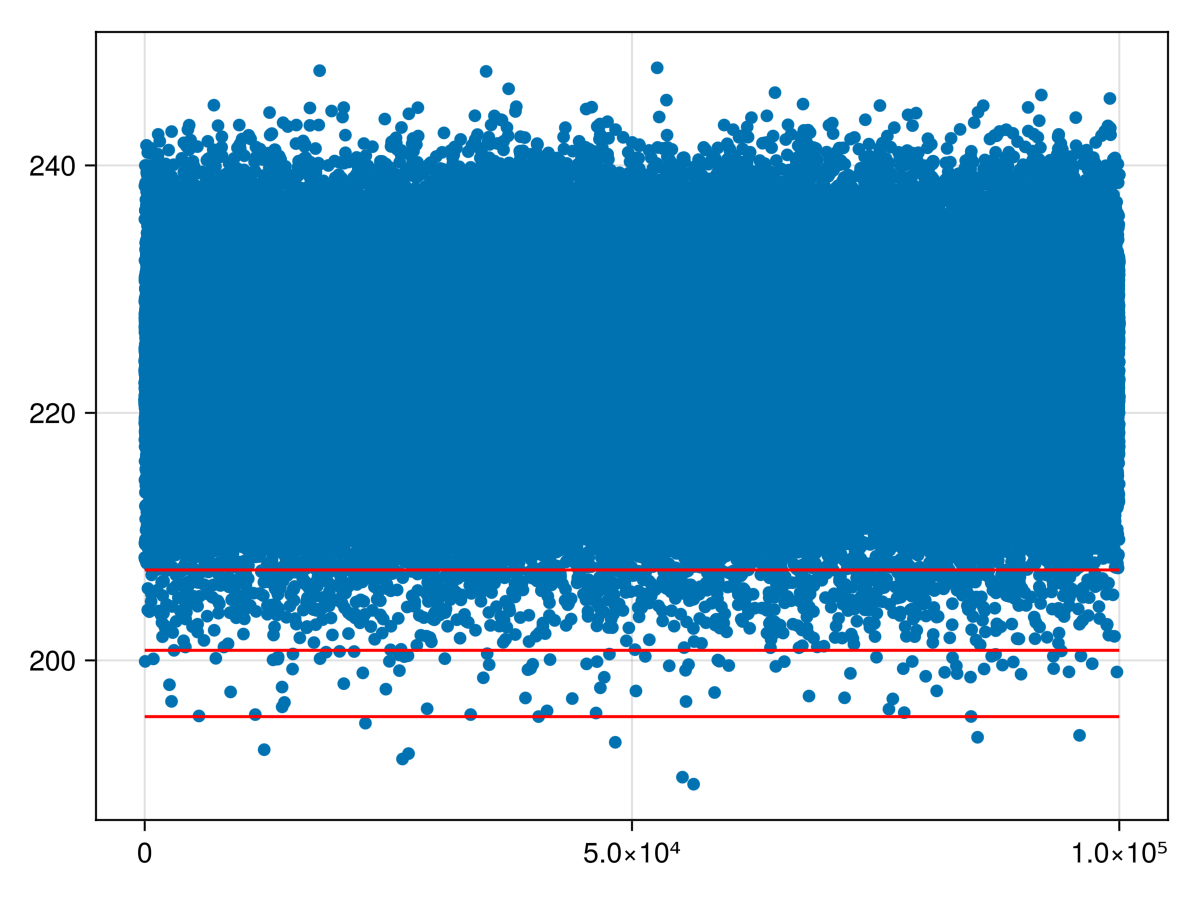

In [25]:
f = Makie.scatter(collect(Iterators.flatten(obs_log_likelihoods)), )
Makie.lines!([0, length(obs_log_likelihoods)] ,[threshold_1_in_100, threshold_1_in_100], color=:red)
Makie.lines!([0, length(obs_log_likelihoods)] ,[threshold_1_in_1000, threshold_1_in_1000], color=:red)
Makie.lines!([0, length(obs_log_likelihoods)] ,[threshold_1_in_10000, threshold_1_in_10000], color=:red)
f

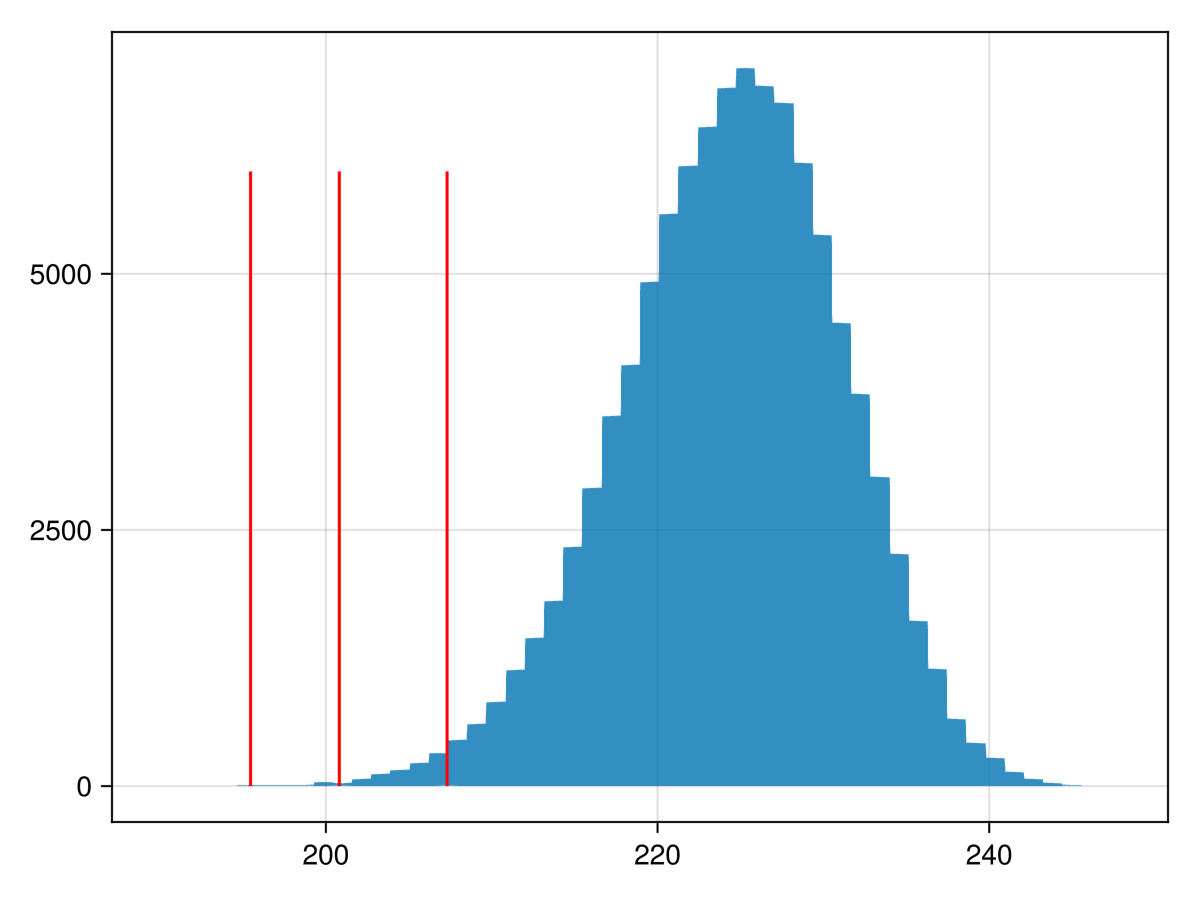

In [26]:
f = Makie.hist(
    collect(Iterators.flatten(obs_log_likelihoods)),
    bins=50,
    normalize=true
)
Makie.lines!([threshold_1_in_100, threshold_1_in_100], [0, 6000], color=:red)
Makie.lines!([threshold_1_in_1000, threshold_1_in_1000], [0, 6000], color=:red)
Makie.lines!([threshold_1_in_10000, threshold_1_in_10000], [0, 6000], color=:red)
f

### Inference controller implementation

In [27]:
function make_inference_controller(threshold)
    # Schedule of increasingly wide and fine grids that the inference controller can try to use.
    init_grid_args = [
        default_pf_args(params; sigma_multiplier=m, coarsest_stepsize=r)[1:2]
        for (m, r) in [(1, 0.4), (1, 0.2), (1, 0.1)]
    ]
    step_grid_args = [
        default_pf_args(params; sigma_multiplier=m, coarsest_stepsize=r)[1:2]
        for (m, r) in [(2, 0.2), (3, 0.2), (4.5, 0.2)]
    ]

    get_pf((t0_grid_args, update_grid_args)) = GenPOMDPs.pf(
        pomdp, params,
        obs -> (2 #=n particles=#, GenSMCP3.SMCP3Update(fwd_iterated_grid, bwd_iterated_grid,
                (true, trajectory_model, params, obs, t0_grid_args, pos_to_init_cm, state_to_pos, nothing, nonoise_nextpos),
                (true, t0_grid_args, state_to_pos, nonoise_nextpos)
            )
        ),
        (action, obs) -> (SMCP3Update(fwd_iterated_grid, bwd_iterated_grid,
                (false, trajectory_model, params, obs, update_grid_args, pos_to_step_cm, state_to_pos, action, nonoise_nextpos),
                (false, update_grid_args, state_to_pos, nonoise_nextpos)),
        ),
        pre_update = GenPOMDPs.stratified_resample_if_ess_below_one_plus_onetenth_particlecount
    )
    pf_inits = [get_pf(grid_args)[1] for grid_args in init_grid_args]
    pf_updates = [get_pf(grid_args)[2] for grid_args in step_grid_args]

    function fails_test(pfstate)
        tr = GenParticleFilters.sample_unweighted_traces(pfstate, 1)[1]
        score = Gen.project(tr, select(GenPOMDPs.obs_addr(get_args(tr)[1])))
        return score < threshold
    end
    function inference_controller_init(obs)
        i = 1
        pfstate = pf_inits[i](obs)
        while fails_test(pfstate) && i < length(pf_inits)
            # print("Init::Trying the next grid...")
            i += 1
            pfstate = pf_inits[i](obs)
        end
        return pfstate
    end
    function inference_controller_update(prev_pfstate, action, obs)
        i = 1
        pfstate = pf_updates[i](prev_pfstate, action, obs)
        while fails_test(pfstate) && i < length(pf_updates)
            # println("Step::Trying the next grid at t=$(get_args(pfstate.traces[1])[1])...")
            i += 1
            pfstate = pf_updates[i](prev_pfstate, action, obs)
        end
        return pfstate
    end
    inference_controller = (inference_controller_init, inference_controller_update)
    return inference_controller
end

ic_1_in_100 = make_inference_controller(threshold_1_in_100)
ic_1_in_1000 = make_inference_controller(threshold_1_in_1000)
ic_1_in_10000 = make_inference_controller(threshold_1_in_10000);

### Plot runtime/step vs step for the inference controller(s)

In [28]:
function timed_map_pf_over_gt_trace(pf, gt_trace; get_intermediates=true)
    (initialize_pf, update_pf) = pf
    obss = GenPOMDPs.observation_sequence(gt_trace)
    actions = GenPOMDPs.action_sequence(gt_trace)

    times = []
    if get_intermediates
        states = []
    end
    time = @elapsed pf_state = initialize_pf(obss[1])
    push!(times, time)

    for (obs, action) in zip(obss[2:end], actions)
        time = @elapsed pf_state = update_pf(pf_state, action, obs)
        push!(times, time)
        if get_intermediates
            push!(states, pf_state)
        end
    end

    if get_intermediates
        return (times, states)
    else
        return (times, pf_state)
    end
end

timed_map_pf_over_gt_trace (generic function with 1 method)

In [67]:
# compile on this run
tr = Gen.simulate(meandering_wallavoiding_agent_model, (2, params))
(times, pf_state) = timed_map_pf_over_gt_trace(ic_1_in_1000, tr; get_intermediates=false)

# then look at times on this run
tr = Gen.simulate(meandering_wallavoiding_agent_model, (200, params))
(times, pf_state) = timed_map_pf_over_gt_trace(ic_1_in_1000, tr; get_intermediates=false)
println("Total time: $(sum(times))")
println("Avg time per step: $(sum(times)/length(times))")
Makie.lines(1:length(times), Vector{Float32}(times), axis=(xlabel="timestep", ylabel="time (s)"))

Step::Trying the next grid at t=17...
Step::Trying the next grid at t=66...
Step::Trying the next grid at t=66...
Total time: 19.762206579000008
Avg time per step: 0.09831943571641795


check if the inference controller tends to need more computation on the same timesteps --

Init::Trying the next grid...Step::Trying the next grid at t=49...
Init::Trying the next grid...Init::Trying the next grid...Step::Trying the next grid at t=49...


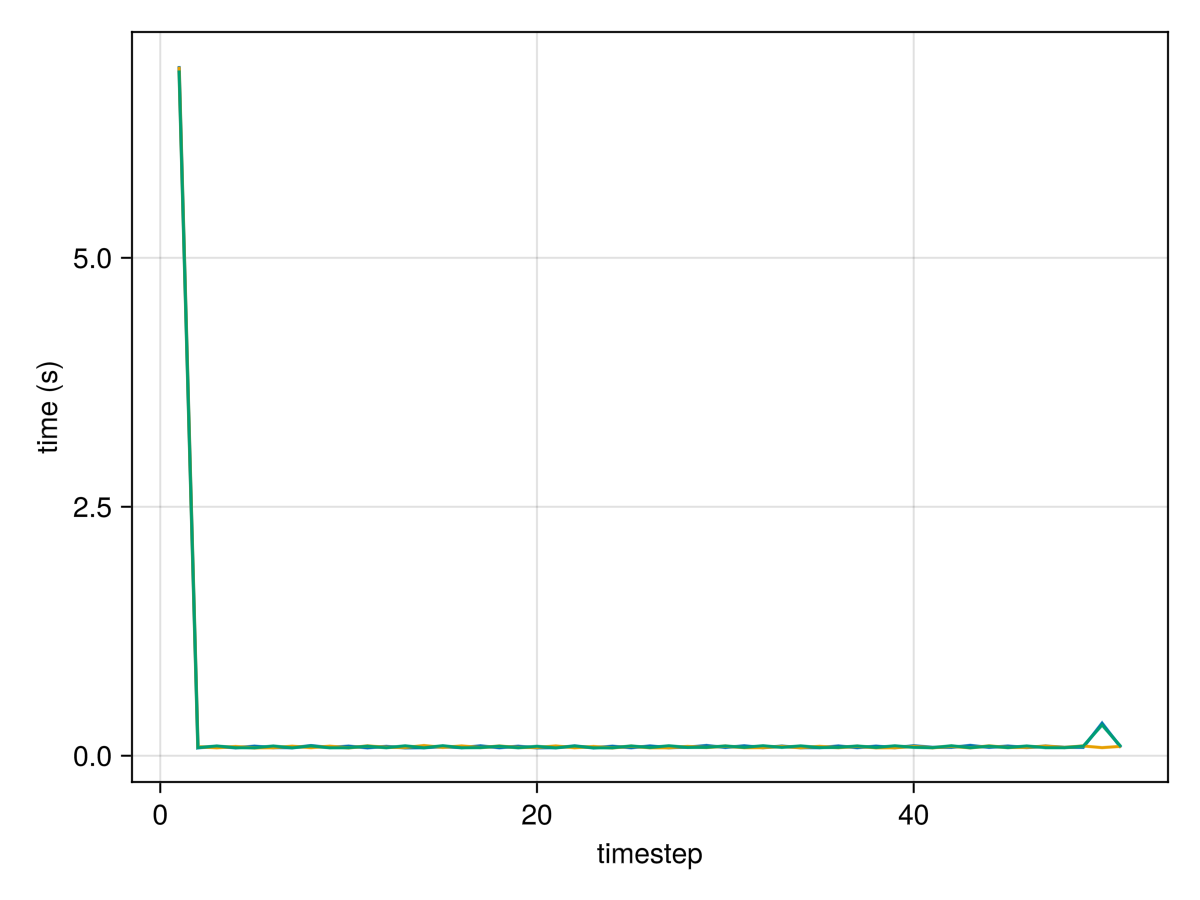

In [73]:
# compile on this run
tr = Gen.simulate(meandering_wallavoiding_agent_model, (2, params))
(times, pf_state) = timed_map_pf_over_gt_trace(ic_1_in_1000, tr; get_intermediates=false)

# then look at times on this run
tr = Gen.simulate(meandering_wallavoiding_agent_model, (50, params))
times = [
    timed_map_pf_over_gt_trace(ic_1_in_1000, tr; get_intermediates=false)[1] for _=1:3
]
f = Makie.Figure()
ax = Makie.Axis(f[1, 1], xlabel="timestep", ylabel="time (s)")
for (i, ts) in enumerate(times)
    Makie.lines!(ax, 1:length(ts), Vector{Float32}(ts))
end
f

Compare IC vs fixed compute budget--

In [75]:
# (; type=:c2f, n_particles, sigma_multiplier [, coarsest_stepsize])
fixed_pf = make_pf(params, (; type=:c2f, n_particles=2, sigma_multiplier=3., coarsest_stepsize=0.2));

In [82]:
# compile on this run
tr = Gen.simulate(meandering_wallavoiding_agent_model, (2, params))
(times, pf_state) = timed_map_pf_over_gt_trace(ic_1_in_1000, tr; get_intermediates=false)
(times, pf_state) = timed_map_pf_over_gt_trace(fixed_pf, tr; get_intermediates=false)

# then look at times on this run
tr = Gen.simulate(meandering_wallavoiding_agent_model, (200, params))
(times_IC, pf_state) = timed_map_pf_over_gt_trace(ic_1_in_1000, tr; get_intermediates=false)
println("Total IC time: $(sum(times_IC))")
println("Avg IC time per step: $(sum(times_IC)/length(times_IC))")
println()

(times_fixed, pf_state) = timed_map_pf_over_gt_trace(fixed_pf, tr; get_intermediates=false)
println("Total fixed time: $(sum(times_fixed))")
println("Avg fixed time per step: $(sum(times_fixed)/length(times_fixed))")

Init::Trying the next grid...Step::Trying the next grid at t=118...
Total IC time: 24.44185721699999
Avg IC time per step: 0.1216012796865671

Total fixed time: 49.663410285
Avg fixed time per step: 0.2470816432089552


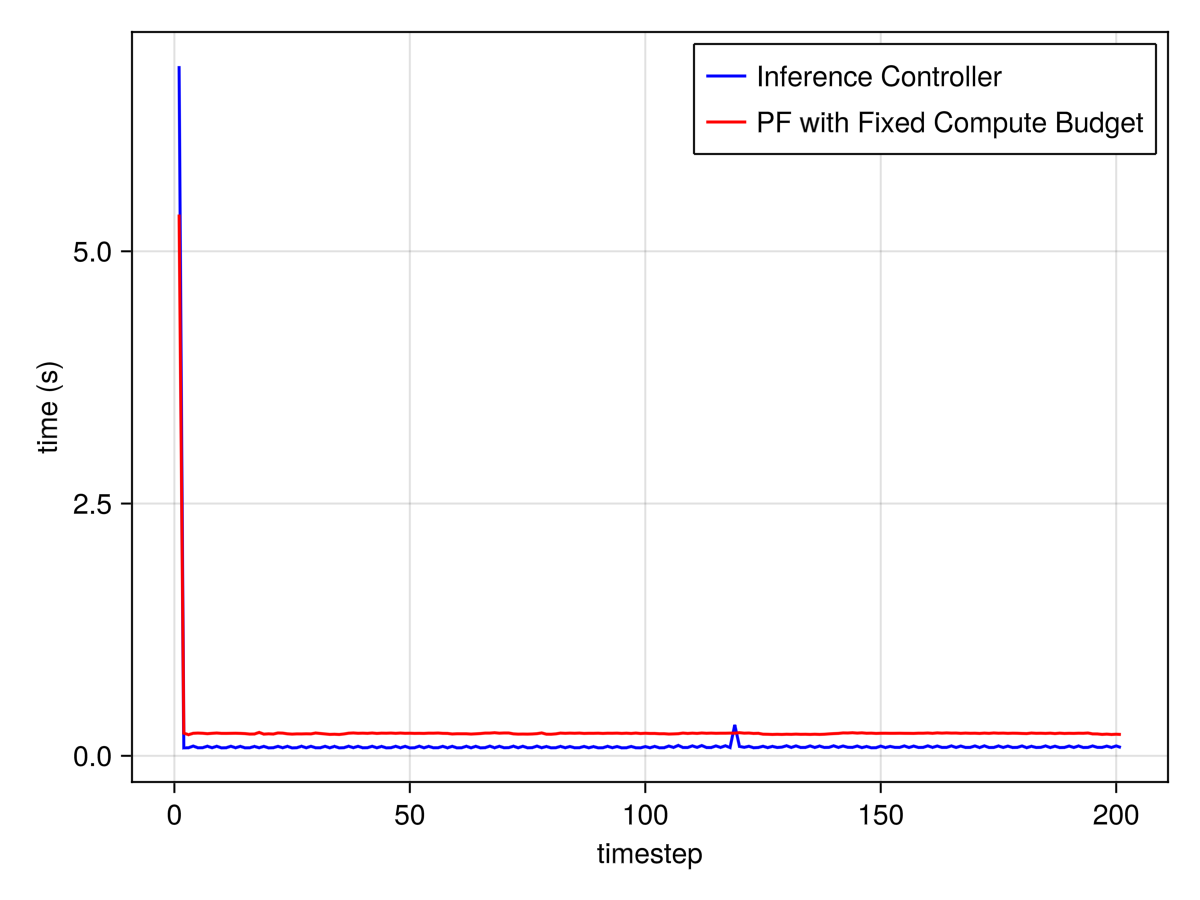

In [83]:
f = Makie.Figure()
ax = Makie.Axis(f[1, 1], xlabel="timestep", ylabel="time (s)")
ic_plt = Makie.lines!(ax, 1:length(times_IC), Vector{Float32}(times_IC), color=:blue)
fixed_plt = Makie.lines!(ax, 1:length(times_fixed), Vector{Float32}(times_fixed), color=:red)
Makie.axislegend(ax, [ic_plt, fixed_plt], ["Inference Controller", "PF with Fixed Compute Budget"])
f

Do one more run (I want one plot where the IC does retry on the first step, and one where it doesn't.)

Init::Trying the next grid...Step::Trying the next grid at t=104...
Step::Trying the next grid at t=104...
Total IC time: 19.665442040000006
Avg IC time per step: 0.09783802009950252

Total fixed time: 49.552921094999995
Avg fixed time per step: 0.24653194574626863


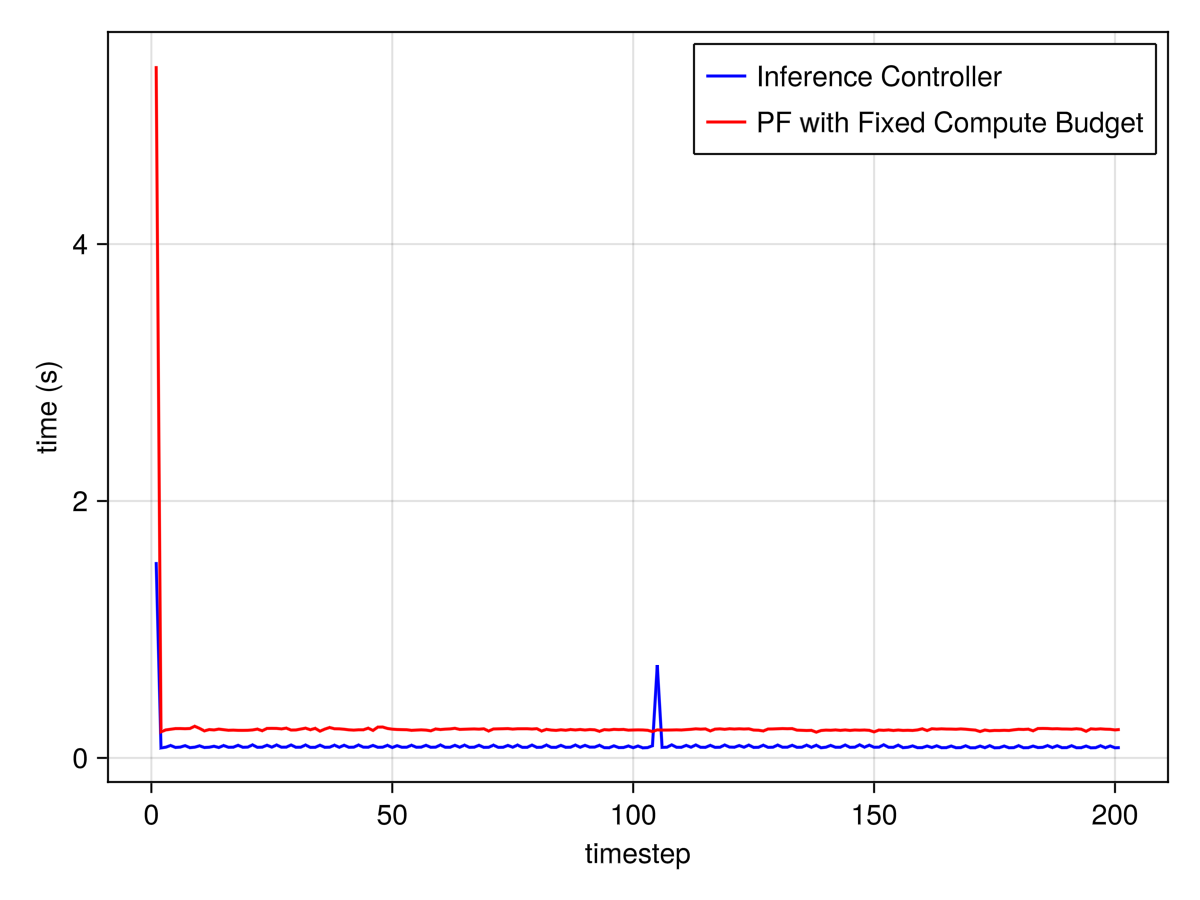

In [86]:
# compile on this run
tr = Gen.simulate(meandering_wallavoiding_agent_model, (2, params))
(times, pf_state) = timed_map_pf_over_gt_trace(ic_1_in_1000, tr; get_intermediates=false)
(times, pf_state) = timed_map_pf_over_gt_trace(fixed_pf, tr; get_intermediates=false)

# then look at times on this run
tr = Gen.simulate(meandering_wallavoiding_agent_model, (200, params))
(times_IC, pf_state) = timed_map_pf_over_gt_trace(ic_1_in_1000, tr; get_intermediates=false)
println("Total IC time: $(sum(times_IC))")
println("Avg IC time per step: $(sum(times_IC)/length(times_IC))")
println()

(times_fixed, pf_state) = timed_map_pf_over_gt_trace(fixed_pf, tr; get_intermediates=false)
println("Total fixed time: $(sum(times_fixed))")
println("Avg fixed time per step: $(sum(times_fixed)/length(times_fixed))")

f = Makie.Figure()
ax = Makie.Axis(f[1, 1], xlabel="timestep", ylabel="time (s)")
ic_plt = Makie.lines!(ax, 1:length(times_IC), Vector{Float32}(times_IC), color=:blue)
fixed_plt = Makie.lines!(ax, 1:length(times_fixed), Vector{Float32}(times_fixed), color=:red)
Makie.axislegend(ax, [ic_plt, fixed_plt], ["Inference Controller", "PF with Fixed Compute Budget"])
f

## Make runtime vs accuracy plot

In [27]:
function make_pf_or_ic(params, spec)
    if spec.type == :inference_controller
        if spec.ic_name == :ic_1_in_1000
            return ic_1_in_1000
        elseif spec.ic_name == :ic_1_in_100
            return ic_1_in_100
        elseif spec.ic_name == :ic_1_in_10000
            return ic_1_in_10000
        else
            error("Unrecognized inference controller name: $(spec.ic_name)")
        end
    else
        return make_pf(params, spec)
    end
end

make_pf_or_ic (generic function with 1 method)

In [28]:
macro probe_runtimes_and_accuracies(
    pf_spec_groups, n_model_trs = 1, n_steps = 10
)
    quote
        pfsets = [
            [make_pf_or_ic(params, pf_spec) for pf_spec in pfset] for pfset in $(esc(pf_spec_groups))
        ]
        probe_runtimes_and_accuracies($(esc(pf_spec_groups)), pfsets; n_model_trs = $(esc(n_model_trs)), n_steps = $(esc(n_steps)))
    end
end

function probe_runtimes_and_accuracies(
    pf_spec_groups, pfsets; n_model_trs = 1, n_steps = 10
)
    """
    pf_spec_groups is a list of lists of pf specs.
    Each list of pf specs is a list of specs of one of the following forms:
    - (; type=:bootstrap, n_particles)
    - (; type=:c2f, n_particles, sigma_multiplier [, coarsest_stepsize])
    - (; type=:inference_controller, ic_name)
    """
    # pfsets = [
    #     [make_pf_or_ic(params, pf_spec) for pf_spec in pfset] for pfset in pf_spec_groups
    # ]
    
    all_pf_states = [
        [Any[nothing for _ in 1:n_model_trs] for pf in pfset] for pfset in pfsets
    ]
    accuracies = [
        [Any[nothing for _ in 1:n_model_trs] for pf in pfset] for pfset in pfsets
    ]

    # runtimes stores vectors of runtime/step; total_runtimes stores total runtime
    runtimes = [
        [Any[nothing for _ in 1:n_model_trs] for pf in pfset] for pfset in pfsets
    ]
    total_runtimes = [
        [Any[nothing for _ in 1:n_model_trs] for pf in pfset] for pfset in pfsets
    ]
    trs = Any[nothing for _ in 1:n_model_trs]

    for tr_idx in 1:n_model_trs
        println("tr_idx: $tr_idx")
        tr = Gen.simulate(meandering_wallavoiding_agent_model, (n_steps, params))
        trs[tr_idx] = tr
        for (pfset_idx, pfset) in enumerate(pfsets)
            for (pf_idx, pf) in enumerate(pfset)
                println("Spec: $(pf_spec_groups[pfset_idx][pf_idx])")
                (times, pf_state) = timed_map_pf_over_gt_trace(pf, tr; get_intermediates=true)
                runtimes[pfset_idx][pf_idx][tr_idx] = times
                total_runtimes[pfset_idx][pf_idx][tr_idx] = sum(times)
                accuracies[pfset_idx][pf_idx][tr_idx] = eval_accuracy(tr, pf_state)
                all_pf_states[pfset_idx][pf_idx][tr_idx] = pf_state
            end
        end
    end

    return (accuracies, runtimes, total_runtimes, all_pf_states, trs)
end

probe_runtimes_and_accuracies (generic function with 1 method)

In [153]:
(accuracies, runtimes, total_runtimes, all_pf_states, trs) = @probe_runtimes_and_accuracies(
    [
        [(; type=:c2f, n_particles=2, sigma_multiplier=s, coarsest_stepsize=0.4) for  s in [1, 2, 4]],
        [(; type=:c2f, n_particles=2, sigma_multiplier=s, coarsest_stepsize=0.2) for  s in [1, 2, 4]],
        [(; type=:inference_controller, ic_name=:ic_1_in_100)],
        [(; type=:inference_controller, ic_name=:ic_1_in_1000)],
        [(; type=:inference_controller, ic_name=:ic_1_in_10000)],
    ],
    15, # n_model_trs
    100 # n_steps
);

tr_idx: 1
Spec: (type = :c2f, n_particles = 2, sigma_multiplier = 1, coarsest_stepsize = 0.4)
Spec: (type = :c2f, n_particles = 2, sigma_multiplier = 2, coarsest_stepsize = 0.4)
Spec: (type = :c2f, n_particles = 2, sigma_multiplier = 4, coarsest_stepsize = 0.4)
Spec: (type = :c2f, n_particles = 2, sigma_multiplier = 1, coarsest_stepsize = 0.2)
Spec: (type = :c2f, n_particles = 2, sigma_multiplier = 2, coarsest_stepsize = 0.2)
Spec: (type = :c2f, n_particles = 2, sigma_multiplier = 4, coarsest_stepsize = 0.2)
Spec: (type = :inference_controller, ic_name = :ic_1_in_100)
Spec: (type = :inference_controller, ic_name = :ic_1_in_1000)
Spec: (type = :inference_controller, ic_name = :ic_1_in_10000)
tr_idx: 2
Spec: (type = :c2f, n_particles = 2, sigma_multiplier = 1, coarsest_stepsize = 0.4)
Spec: (type = :c2f, n_particles = 2, sigma_multiplier = 2, coarsest_stepsize = 0.4)
Spec: (type = :c2f, n_particles = 2, sigma_multiplier = 4, coarsest_stepsize = 0.4)
Spec: (type = :c2f, n_particles = 2, s

In [156]:
[[sum(tr) for tr in trr] for trr in total_runtimes]

5-element Vector{Vector{Float64}}:
 [42.818173226, 67.26312318299999, 166.35459418999997]
 [120.87153096499999, 209.86824126700003, 565.2353289509999]
 [214.13090182900004]
 [178.101156648]
 [199.688502774]

In [158]:
[[sum(a) for a in aa] for aa in accuracies]

5-element Vector{Vector{Float64}}:
 [1057.0, 567.0, 451.0]
 [560.0, 4.0, 0.0]
 [0.0]
 [0.0]
 [0.0]

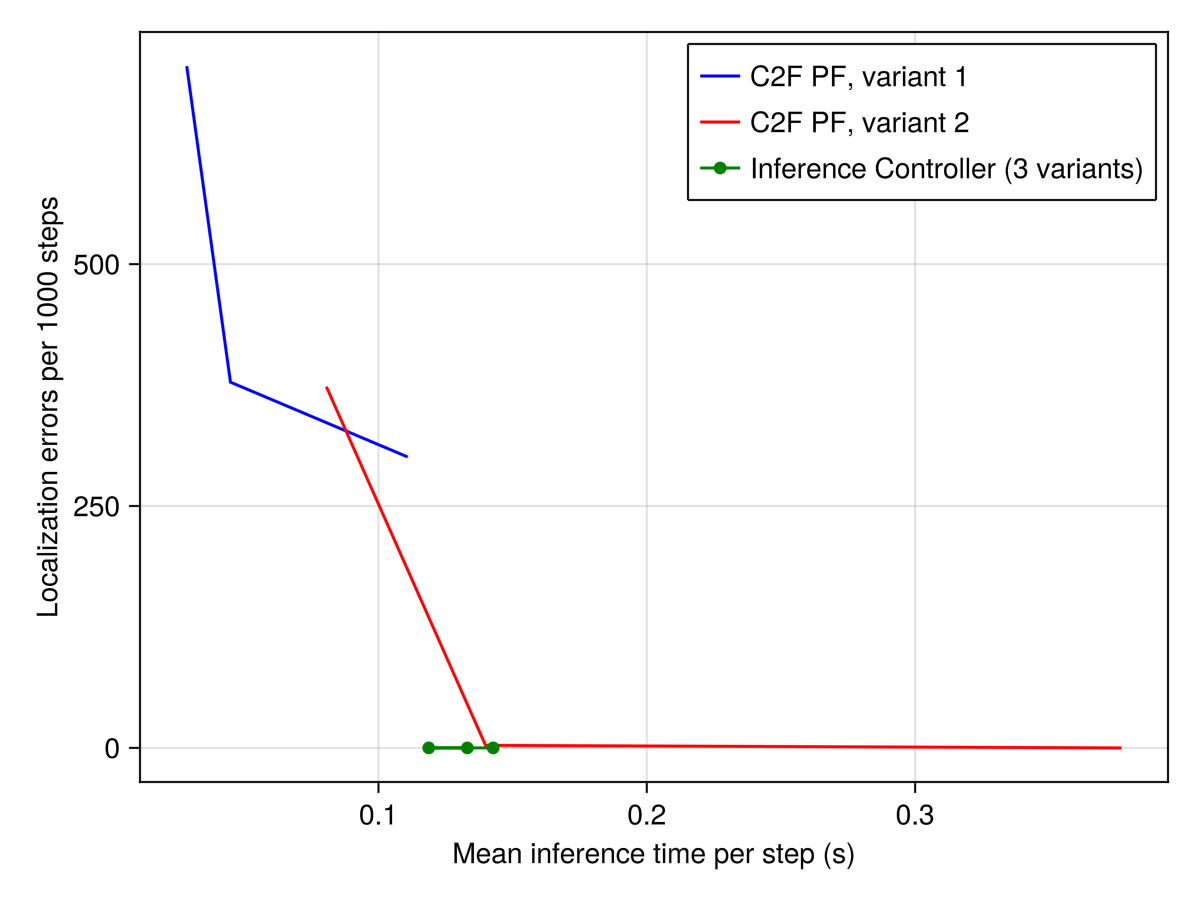

In [172]:
time_per_steps = [[sum(tr) / (15 * 100) for tr in trr] for trr in total_runtimes]
errors_per_1000 = [[1000 * sum(a) / (15 * 100) for a in aa] for aa in accuracies]

f = Makie.Figure()
ax = Makie.Axis(f[1, 1], ylabel="Localization errors per 1000 steps", xlabel="Mean inference time per step (s)")
p1 = Makie.lines!(ax, time_per_steps[1], errors_per_1000[1], color=:blue)
p2 = Makie.lines!(ax, time_per_steps[2], errors_per_1000[2], color=:red)
p3 = Makie.lines!(ax, [time_per_steps[i][1] for i in 3:5], [errors_per_1000[i][1] for i in 3:5], color=:green)
p3_ = Makie.scatter!(ax, [time_per_steps[i][1] for i in 3:5], [errors_per_1000[i][1] for i in 3:5], color=:green)
Makie.axislegend(ax, [p1, p2, [p3, p3_]], ["C2F PF, variant 1", "C2F PF, variant 2", "Inference Controller (3 variants)"])
f

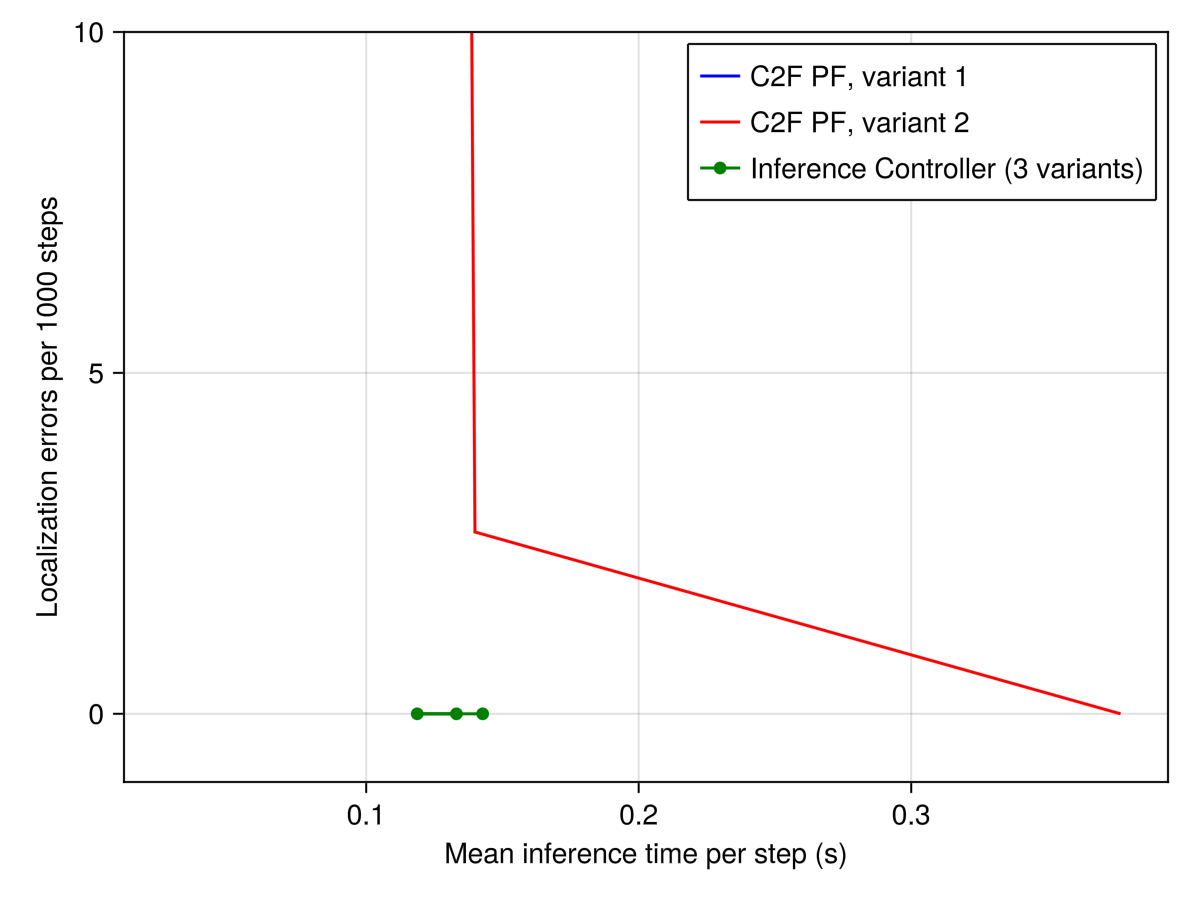

In [173]:
time_per_steps = [[sum(tr) / (15 * 100) for tr in trr] for trr in total_runtimes]
errors_per_1000 = [[1000 * sum(a) / (15 * 100) for a in aa] for aa in accuracies]

f = Makie.Figure()
ax = Makie.Axis(f[1, 1], ylabel="Localization errors per 1000 steps", xlabel="Mean inference time per step (s)")
p1 = Makie.lines!(ax, time_per_steps[1], errors_per_1000[1], color=:blue)
p2 = Makie.lines!(ax, time_per_steps[2], errors_per_1000[2], color=:red)
p3 = Makie.lines!(ax, [time_per_steps[i][1] for i in 3:5], [errors_per_1000[i][1] for i in 3:5], color=:green)
p3_ = Makie.scatter!(ax, [time_per_steps[i][1] for i in 3:5], [errors_per_1000[i][1] for i in 3:5], color=:green)
Makie.axislegend(ax, [p1, p2, [p3, p3_]], ["C2F PF, variant 1", "C2F PF, variant 2", "Inference Controller (3 variants)"])
Makie.ylims!(ax, (-1, 10))
f

In [178]:
# serialize: accuracies, runtimes, total_runtimes, trs

fname = "saves/" * string(Dates.now()) * "_timing_accuracy_results.jld"
Utils.Serialization.serialize(
    fname,
    Dict(
        "accuracies" => accuracies,
        "runtimes" => runtimes,
        "total_runtimes" => total_runtimes,
        "trs" => [Utils.pomdp_trace_to_serializable(tr) for tr in trs]
    )
)
println("Saved to $fname")

Saved to saves/2023-12-30T16:37:11.624_timing_accuracy_results.jld


In [179]:
Utils.Serialization.deserialize("saves/2023-12-30T16:37:11.624_timing_accuracy_results.jld")

Dict{String, Vector} with 4 entries:
  "runtimes"       => Vector{Vector{Any}}[[[Any[1.85665, 0.511104, 0.017461, 0.…
  "accuracies"     => Vector{Vector{Any}}[[[67.0, 45.0, 94.0, 50.0, 54.0, 92.0,…
  "total_runtimes" => Vector{Vector{Any}}[[[3.70301, 2.8066, 2.81853, 2.7908, 2…
  "trs"            => Dict{String, Tuple{Any, Any}}[Dict("choices"=>(Union{}[],…

## Inference steps visualization

In [29]:
function make_c2f_pf_with_steps_saver(params, n_particles, sigma_multiplier; coarsest_stepsize=0.2)
    """
    Returns a c2f pf set up so that the grids used during inference are saved at each step.
    Also returns a vector `grids` which will be filled with the saved grids.
    Each time an inference step is run, `grids` will be appended with a vector of grids used
    at that step of inference.
    """
    
    (t0_grid_args, update_grid_args, _) = default_pf_args(params; sigma_multiplier, coarsest_stepsize)

    grids = Ref([])
    function grid_saver(grid)
        push!(grids[][end], grid)
    end

    pf_init, pf_update = GenPOMDPs.pf(
        pomdp, params,
        obs -> (
            n_particles,
            GenSMCP3.SMCP3Update(
                fwd_iterated_grid, bwd_iterated_grid,
                (
                    true, trajectory_model, params, obs, t0_grid_args,
                    pos_to_init_cm, state_to_pos, nothing, nonoise_nextpos,
                    grid_saver
                ),
                (true, t0_grid_args, state_to_pos, nonoise_nextpos)
            )
        ),
        (action, obs) -> (
            SMCP3Update(
                fwd_iterated_grid, bwd_iterated_grid,
                (
                    false, trajectory_model, params, obs, update_grid_args,
                    pos_to_step_cm, state_to_pos, action, nonoise_nextpos,
                    grid_saver
                ),
                (false, update_grid_args, state_to_pos, nonoise_nextpos)
            
            ),
        ),
        pre_update = GenPOMDPs.stratified_resample_if_ess_below_one_plus_onetenth_particlecount
    );

    function init(obs)
        grids[] = [[]]
        return pf_init(obs)
    end
    function update(prev_pfstate, action, obs)
        push!(grids[], [])
        return pf_update(prev_pfstate, action, obs)
    end

    return (init, update), grids
end

make_c2f_pf_with_steps_saver (generic function with 1 method)

In [208]:
# include("src/inference.jl")

default_pf_args (generic function with 1 method)

In [240]:
import Makie: Observable, @lift

function make_anim_sequence(tr, pf_states, grids; max_n_grid_iters=nothing)
    sequence = []
    # (ΔT, current_timestep, grid_steps, n_grid_elems_to_show, show_new_path, label)
    n_timesteps = length(pf_states) - 1
    n_grid_steps = isnothing(max_n_grid_iters) ? length(grids[][2]) : min(length(grids[][2]), max_n_grid_iters)
    for i=1:n_timesteps
        push!(sequence, (1, i, 0, 0, false, "Get observation @ t=$i"))
        n_grid_elems = 0
        for j=1:n_grid_steps
            n_grid_elems = length(grids[][i][j])
            for k=1:n_grid_elems
                if i == 1
                    label = "Initialize via global grid scan + coarse-to-fine refinement"
                else
                    label = "Extend trajectory via coarse-to-fine PF update"
                end
                push!(sequence, (0.001, i, j, k, false, label))
            end
        end
        push!(sequence, (0.5, i, n_grid_steps, n_grid_elems, true, "Trajectory extended to t=$i"))
    end
    return sequence
end
function full_sequence_to_fps(sequence, fps)
    subsequence = []
    next_frame_time = 0
    t = 0 # at beginning of this element in the sequence, what time is it?
    for (ΔT, vals...) in sequence
        t += ΔT
        while t >= next_frame_time
            push!(subsequence, vals)
            next_frame_time += 1/fps
        end
    end
    return subsequence
end

ANIM_IDX = 0
run_anim(observables, tr, pf_states, grids; kwargs...) = run_anim(observables, make_anim_sequence(tr, pf_states, grids; kwargs...))
function run_anim(observables, sequence)
    global ANIM_IDX
    (current_timestep, grid_steps, n_grid_elems_to_show, show_new_path, current_label) = observables
    ANIM_IDX += 1
    idx = ANIM_IDX
    task = @async for (j, (ΔT, ct, gs, nge, snp, label)) in enumerate(sequence) # enumerate(sequence[10500:end]) in# enumerate(sequence[10_700:10_720])
        if ANIM_IDX > idx
            break
        end
        try
            n_grid_elems_to_show[] = 1
            grid_steps[] = 1
    
            current_timestep[] = ct
            n_grid_elems_to_show[] = nge
            grid_steps[] = gs
            show_new_path[] = snp
            current_label[] = label
        catch
            println("Current vals: $((current_timestep[], grid_steps[], n_grid_elems_to_show[], show_new_path[]))")
            println("New vals: $ct, $gs, $nge, $snp")
            error()
        end
        sleep(ΔT)
    end
end


import Printf
function make_anim_fig(tr, pf_states, grids)
    current_timestep = Observable(2)
    grid_steps = Observable(1)
    n_grid_elems_to_show = Observable(2)
    show_new_path = Observable(false)
    current_label = Observable("")
    observables = (current_timestep, grid_steps, n_grid_elems_to_show, show_new_path, current_label)

    path_visible_timestep = @lift($show_new_path ? $current_timestep : $current_timestep - 1)
    
    inferred_paths_to_this_point = Makie.@lift(
        $path_visible_timestep > 0 ? [
            [pos for (pos, _, _) in GenPOMDPs.state_sequence(trace)]
            for trace in get_traces(pf_states[$path_visible_timestep])
        ] : [
            [[NaN, NaN] for (pos, _, _) in GenPOMDPs.state_sequence(trace)]
            for trace in get_traces(pf_states[1])
        ]
    )
    grids_present = Makie.@lift(
        $grid_steps == 0 ? [[]] : [
            j == length(grids[][$current_timestep][1:$grid_steps]) ? grid[1:$n_grid_elems_to_show] : grid
            for (j, grid) in enumerate(grids[][$current_timestep][1:$grid_steps])
        ])
    # Makie.Observable(grids[][1])#
    path_weights = Makie.@lift(
        $path_visible_timestep > 0 ? get_log_weights(pf_states[$path_visible_timestep]) : [
            NaN for trace in get_traces(pf_states[1])
        ]
    )
    current_obs = Makie.@lift(GenPOMDPs.observation_retval_sequence(tr)[$current_timestep])
    # Makie.lift(current_timestep, grid_steps, show_new_path) do current_timestep, grid_steps, show_new_path
    #     if grid_steps ==
    # end
    
    gridsize = length(grids[][2][1])
    stepsize = grids[][2][1][2][1] - grids[][2][1][1][1]
    stepsize_str = Printf.@sprintf("%.2f", stepsize)
    f = GridWorlds.Viz.inference_steps_animation(
        Makie.Observable(get_args(tr)[2].map),
        inferred_paths_to_this_point,
        path_weights,
        current_obs,
        grids_present,
        current_label,
        title="Inference: Fixed Coarse-To-Fine PF (stepsize=$stepsize_str, gridsize=$gridsize)"
    )

    return (f, observables)
end

make_anim_fig (generic function with 1 method)

In [213]:
tr, _ = Gen.generate(meandering_wallavoiding_agent_model, (30, params), choicemap((GenPOMDPs.state_addr(0, :cell), (8, 9))))

(GenPOMDPs.var"##StaticIRTrace__RolloutModel#640"(30, (map = GridWorlds.FGridWorld(FunctionalCollections.PersistentVector{GridWorlds.GridCell}[[GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall], [GridWorlds.wall, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.wall], [GridWorlds.wall, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.wall], [GridWorlds.wall, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.wall], [GridWorlds.wall, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, G

In [252]:
pf2, grids2 = make_c2f_pf_with_steps_saver(params, 1, 2.; coarsest_stepsize=0.4);
pf_states2 = GenPOMDPs.map_pf_over_gt_trace_fixed(pf2, tr);

In [253]:
f, observables = make_anim_fig(tr, pf_states2, grids2)
display(f)

GLMakie.Screen(...)

In [254]:
# Quickly scan through the trace to see how well inference worked:
observables[4][] = true
for i in 1:30
    observables[1][] = i
    sleep(0.1)
end

In [221]:
run_anim(observables, tr, pf_states, grids; max_n_grid_iters=1)

Task (runnable) @0x00000003cdd26bd0

In [256]:
sequence = make_anim_sequence(tr, pf_states2, grids2; max_n_grid_iters=5)
subsequence = full_sequence_to_fps(sequence, 30);

In [242]:
sum(dt for (dt, _) in sequence)

87.39400000002563

In [257]:
(current_timestep, grid_steps, n_grid_elems_to_show, show_new_path, current_label) = observables
Makie.record(f, "smallgrid_c2f_fail.mp4", 1:length(subsequence); framerate=30) do i
    (ct, gs, nge, snp, label) = subsequence[i]
    try
        n_grid_elems_to_show[] = 1
        grid_steps[] = 1

        current_timestep[] = ct
        n_grid_elems_to_show[] = nge
        grid_steps[] = gs
        show_new_path[] = snp
        current_label[] = label
    catch
        println("Current vals: $((current_timestep[], grid_steps[], n_grid_elems_to_show[], show_new_path[]))")
        println("New vals: $ct, $gs, $nge, $snp")
        error()
    end
end

"smallgrid_c2f_fail.mp4"

bigger grid + inference success--

In [219]:
pf, grids = make_c2f_pf_with_steps_saver(params, 1, 4.; coarsest_stepsize=0.2);
pf_states = GenPOMDPs.map_pf_over_gt_trace_fixed(pf, tr);

GLMakie.Screen(...)

In [258]:
f, observables = make_anim_fig(tr, pf_states, grids)
display(f)

GLMakie.Screen(...)

In [259]:
# Quickly scan through the trace to see how well inference worked:
observables[4][] = true
for i in 1:30
    observables[1][] = i
    sleep(0.1)
end

In [260]:
sequence = make_anim_sequence(tr, pf_states, grids; max_n_grid_iters=5)
subsequence = full_sequence_to_fps(sequence, 30);

In [261]:
(current_timestep, grid_steps, n_grid_elems_to_show, show_new_path, current_label) = observables
Makie.record(f, "biggrid_c2f_success.mp4", 1:length(subsequence); framerate=30) do i
    (ct, gs, nge, snp, label) = subsequence[i]
    try
        n_grid_elems_to_show[] = 1
        grid_steps[] = 1

        current_timestep[] = ct
        n_grid_elems_to_show[] = nge
        grid_steps[] = gs
        show_new_path[] = snp
        current_label[] = label
    catch
        println("Current vals: $((current_timestep[], grid_steps[], n_grid_elems_to_show[], show_new_path[]))")
        println("New vals: $ct, $gs, $nge, $snp")
        error()
    end
end

"biggrid_c2f_success.mp4"

## inference controller step-by-step animation

In [292]:
function make_inference_controller_with_grid_saving(threshold)
    grids = Ref([])
    function grid_saver(grid)
        push!(grids[][end], grid)
    end

    # Schedule of increasingly wide and fine grids that the inference controller can try to use.
    init_grid_args = [
        default_pf_args(params; sigma_multiplier=m, coarsest_stepsize=r)[1:2]
        for (m, r) in [(1, 0.4), (1, 0.2), (1, 0.1)]
    ]
    step_grid_args = [
        default_pf_args(params; sigma_multiplier=m, coarsest_stepsize=r)[1:2]
        for (m, r) in [(2, 0.4), (3, 0.2), (4.5, 0.2)]
    ]

    get_pf((t0_grid_args, update_grid_args)) = GenPOMDPs.pf(
        pomdp, params,
        obs -> (1 #=n particles=#, GenSMCP3.SMCP3Update(fwd_iterated_grid, bwd_iterated_grid,
                (true, trajectory_model, params, obs, t0_grid_args, pos_to_init_cm, state_to_pos, nothing, nonoise_nextpos, grid_saver),
                (true, t0_grid_args, state_to_pos, nonoise_nextpos)
            )
        ),
        (action, obs) -> (SMCP3Update(fwd_iterated_grid, bwd_iterated_grid,
                (false, trajectory_model, params, obs, update_grid_args, pos_to_step_cm, state_to_pos, action, nonoise_nextpos, grid_saver),
                (false, update_grid_args, state_to_pos, nonoise_nextpos)),
        ),
        pre_update = GenPOMDPs.stratified_resample_if_ess_below_one_plus_onetenth_particlecount
    )
    pf_inits = [get_pf(grid_args)[1] for grid_args in init_grid_args]
    pf_updates = [get_pf(grid_args)[2] for grid_args in step_grid_args]

    function fails_test(pfstate)
        tr = GenParticleFilters.sample_unweighted_traces(pfstate, 1)[1]
        score = Gen.project(tr, select(GenPOMDPs.obs_addr(get_args(tr)[1])))
        return score < threshold
    end
    function inference_controller_init(obs)
        i = 1
        pfstate = pf_inits[i](obs)
        while fails_test(pfstate) && i < length(pf_inits)
            # print("Init::Trying the next grid...")
            i += 1
            pfstate = pf_inits[i](obs)
        end
        return pfstate
    end
    function inference_controller_update(prev_pfstate, action, obs)
        i = 1
        pfstate = pf_updates[i](prev_pfstate, action, obs)
        while fails_test(pfstate) && i < length(pf_updates)
            # println("Step::Trying the next grid at t=$(get_args(pfstate.traces[1])[1])...")
            i += 1
            pfstate = pf_updates[i](prev_pfstate, action, obs)
        end
        return pfstate
    end

    function init(obs)
        grids[] = [[]]
        return inference_controller_init(obs)
    end
    function update(prev_pfstate, action, obs)
        push!(grids[], [])
        return inference_controller_update(prev_pfstate, action, obs)
    end

    return (init, update), grids
end

ic_1_in_1000, ic_grids = make_inference_controller_with_grid_saving(threshold_1_in_1000);

In [381]:
function make_ic_anim_fig(tr, pf_states, grids)
    current_timestep = Observable(2)
    current_grid_attempt = Observable(1)
    grid_steps = Observable(1)
    n_grid_elems_to_show = Observable(2)
    show_new_path = Observable(false)
    current_label = Observable("")
    observables = (current_timestep, current_grid_attempt, grid_steps, n_grid_elems_to_show, show_new_path, current_label)

    path_visible_timestep = @lift($show_new_path ? $current_timestep : $current_timestep - 1)
    
    inferred_paths_to_this_point = Makie.@lift(
        $path_visible_timestep > 0 ? [
            [pos for (pos, _, _) in GenPOMDPs.state_sequence(trace)]
            for trace in get_traces(pf_states[$path_visible_timestep])
        ] : [
            [[NaN, NaN] for (pos, _, _) in GenPOMDPs.state_sequence(trace)]
            for trace in get_traces(pf_states[1])
        ]
    )
    grids_present = Makie.@lift(
        $grid_steps == 0 ? [[]] : [
            j == length(grids[$current_timestep][$current_grid_attempt][1:$grid_steps]) ? grid[1:$n_grid_elems_to_show] : grid
            for (j, grid) in enumerate(grids[$current_timestep][$current_grid_attempt][1:$grid_steps])
        ])
    # Makie.Observable(grids[][1])#
    path_weights = Makie.@lift(
        $path_visible_timestep > 0 ? get_log_weights(pf_states[$path_visible_timestep]) : [
            NaN for trace in get_traces(pf_states[1])
        ]
    )
    current_obs = Makie.@lift(GenPOMDPs.observation_retval_sequence(tr)[$current_timestep])
    # Makie.lift(current_timestep, grid_steps, show_new_path) do current_timestep, grid_steps, show_new_path
    #     if grid_steps ==
    # end
    
    f = GridWorlds.Viz.inference_steps_animation(
        Makie.Observable(get_args(tr)[2].map),
        inferred_paths_to_this_point,
        path_weights,
        current_obs,
        grids_present,
        current_label,
        title="Inference Controller (coarse-to-fine w/ adaptive grid parameters)"
    )

    return (f, observables)
end

function make_ic_anim_sequence(tr, pf_states, grids; max_n_grid_iters=nothing)
    n_grids_no_repeat = minimum(length.(grids[]))
    timestep_to_grid_attempts = []
    for i in 1:length(grids[])
        seqlen = i == 1 ? n_grids_no_repeat + 1 : n_grids_no_repeat
        grid_seq = copy(grids[][i])
        gridseqs_here = []
        while length(grid_seq) > seqlen
            push!(gridseqs_here, grid_seq[1:seqlen])
            grid_seq = grid_seq[seqlen+1:end]
        end
        push!(gridseqs_here, grid_seq)
        push!(timestep_to_grid_attempts, gridseqs_here)
    end

    # flattened_grids = collect(Iterators.flatten(timestep_to_grid_attempts))
    # # flattened_grids[$current_timestep][1:$grid_steps]
    
    sequence = []
    # (ΔT, current_timestep, current_grid_attempt, grid_steps, n_grid_elems_to_show, show_new_path, label)
    n_timesteps = length(pf_states) - 1
    n_grid_steps = isnothing(max_n_grid_iters) ? length(grids[][2]) : min(length(grids[][2]), max_n_grid_iters)
    for i=1:n_timesteps
        push!(sequence, (1, i, 1, 0, 0, false, "Get observation @ t=$i"))
        n_grid_elems = 0
        
        for u=1:length(timestep_to_grid_attempts[i])
            for j=1:min(n_grid_steps, length(timestep_to_grid_attempts[i][u]))
                n_grid_elems = length(timestep_to_grid_attempts[i][u][j])
                for k=1:n_grid_elems
                    if u == 1
                        if i == 1
                            label = "Initialize via global grid scan + coarse-to-fine refinement"
                        else
                            label = "Extend trajectory via coarse-to-fine PF update"
                        end
                    else
                        label = "Retry with finer + wider grid"
                    end
                    push!(sequence, (0.001, i, u, j, k, false, label))
                end
            end
        end
        push!(sequence, (0.5, i, length(timestep_to_grid_attempts[i]), n_grid_steps, n_grid_elems, true, "Trajectory extended to t=$i"))
    end

    return sequence, timestep_to_grid_attempts
end

function run_ic_anim(observables, sequence)
    global ANIM_IDX
    (current_timestep, current_grid_attempt, grid_steps, n_grid_elems_to_show, show_new_path, current_label) = observables
    ANIM_IDX += 1
    idx = ANIM_IDX
    for (j, (ΔT, ct, cga, gs, nge, snp, label)) in enumerate(sequence) # enumerate(sequence[10500:end]) in# enumerate(sequence[10_700:10_720])
        if ANIM_IDX > idx
            break
        end
        try
            n_grid_elems_to_show[] = 1
            current_grid_attempt[] = 1
            grid_steps[] = 1
    
            current_timestep[] = ct
            current_grid_attempt[] = cga
            n_grid_elems_to_show[] = nge
            grid_steps[] = gs
            show_new_path[] = snp
            current_label[] = label
        catch e
            println("ERROR RUNNING ANIMATION")
            println("Current vals: $((current_timestep[], current_grid_attempt[], grid_steps[], n_grid_elems_to_show[], show_new_path[]))")
            println("New vals: $ct, $cga, $gs, $nge, $snp")
            println(e)
            error()
        end
        sleep(ΔT)
    end
end

run_ic_anim (generic function with 1 method)

In [382]:
ic_states = GenPOMDPs.map_pf_over_gt_trace_fixed(ic_1_in_1000, tr);

In [388]:
(seq, grid_attempts) = make_ic_anim_sequence(tr, ic_states, ic_grids; max_n_grid_iters=5);

In [389]:
f, observables = make_ic_anim_fig(tr, ic_states, grid_attempts)
display(f)

GLMakie.Screen(...)

In [390]:
unique([x[3] for x in seq])|>collect

2-element Vector{Int64}:
 1
 2

In [387]:
run_ic_anim(observables, seq)

In [394]:
# Record this animation:

subsequence = full_sequence_to_fps(seq, 30);
(current_timestep, current_grid_attempt, grid_steps, n_grid_elems_to_show, show_new_path, current_label) = observables
Makie.record(f, "ic_animation.mp4", 1:length(subsequence); framerate=30) do i
    (ct, cga, gs, nge, snp, label) = subsequence[i]
    try
        n_grid_elems_to_show[] = 1
        current_grid_attempt[] = 1
        grid_steps[] = 1

        current_timestep[] = ct
        current_grid_attempt[] = cga
        n_grid_elems_to_show[] = nge
        grid_steps[] = gs
        show_new_path[] = snp
        current_label[] = label
    catch e
        println("ERROR RUNNING ANIMATION")
        println("Current vals: $((current_timestep[], current_grid_attempt[], grid_steps[], n_grid_elems_to_show[], show_new_path[]))")
        println("New vals: $ct, $cga, $gs, $nge, $snp")
        println(e)
        error()
    end
end


"ic_animation.mp4"

In [277]:
params.obs

(fov = 6.283185307179586, n_rays = 90, orientation = 1.5707963267948966, wall_sensor_args = (w = 5, s_noise = 0.02, outlier = 0.0001, outlier_vol = 100.0, zmax = 100.0, σ = 0.005))

In [279]:
log(1/2, 0.005/0.4)

6.3219280948873635

In [287]:
target_fineness = params.obs.wall_sensor_args.s_noise / 4

0.005

In [289]:
n_steps_c2f = Int(ceil(log(2/3, target_fineness/0.4)))


11

In [297]:
minimum(length.(ic_grids[]))

11

In [290]:
ic_grids[][2][1]

16-element Vector{Vector{Float64}}:
 [7.136324468354803, 7.097556892558114]
 [7.5363244683548025, 7.097556892558114]
 [7.936324468354803, 7.097556892558114]
 [8.336324468354803, 7.097556892558114]
 [7.136324468354803, 7.497556892558113]
 [7.5363244683548025, 7.497556892558113]
 [7.936324468354803, 7.497556892558113]
 [8.336324468354803, 7.497556892558113]
 [7.136324468354803, 7.897556892558113]
 [7.5363244683548025, 7.897556892558113]
 [7.936324468354803, 7.897556892558113]
 [8.336324468354803, 7.897556892558113]
 [7.136324468354803, 8.297556892558113]
 [7.5363244683548025, 8.297556892558113]
 [7.936324468354803, 8.297556892558113]
 [8.336324468354803, 8.297556892558113]

In [291]:
ic_grids[][2][12]

16-element Vector{Vector{Float64}}:
 [7.136324468354803, 7.097556892558114]
 [7.5363244683548025, 7.097556892558114]
 [7.936324468354803, 7.097556892558114]
 [8.336324468354803, 7.097556892558114]
 [7.136324468354803, 7.497556892558113]
 [7.5363244683548025, 7.497556892558113]
 [7.936324468354803, 7.497556892558113]
 [8.336324468354803, 7.497556892558113]
 [7.136324468354803, 7.897556892558113]
 [7.5363244683548025, 7.897556892558113]
 [7.936324468354803, 7.897556892558113]
 [8.336324468354803, 7.897556892558113]
 [7.136324468354803, 8.297556892558113]
 [7.5363244683548025, 8.297556892558113]
 [7.936324468354803, 8.297556892558113]
 [8.336324468354803, 8.297556892558113]

In [276]:
length.(ic_grids[])

31-element Vector{Int64}:
 24
 22
 22
 22
 22
 22
 22
 22
 22
 42
 22
 22
 42
  ⋮
 22
 22
 22
 22
 22
 22
 42
 22
 22
 22
 42
 22

## scratch work below here

In [248]:
methods(Makie.record)

# 2 methods for generic function "record" from Makie:
 [1] record(func, figlike::Union{Makie.Figure, Makie.FigureAxisPlot, Makie.Scene}, path::AbstractString, iter; kw_args...)
     @ ~/.julia/packages/Makie/Qvk4f/src/recording.jl:152
 [2] record(func, figlike::Union{Makie.Figure, Makie.FigureAxisPlot, Makie.Scene}, path::AbstractString; kw_args...)
     @ ~/.julia/packages/Makie/Qvk4f/src/recording.jl:146

In [ ]:
global ANIM_IDX
(current_timestep, grid_steps, n_grid_elems_to_show, show_new_path, current_label) = observables
ANIM_IDX += 1
idx = ANIM_IDX
task = @async for (j, (ΔT, ct, gs, nge, snp, label)) in enumerate(sequence) # enumerate(sequence[10500:end]) in# enumerate(sequence[10_700:10_720])
    if ANIM_IDX > idx
        break
    end
    sleep(ΔT)
    try
        n_grid_elems_to_show[] = 1
        grid_steps[] = 1

        current_timestep[] = ct
        n_grid_elems_to_show[] = nge
        grid_steps[] = gs
        show_new_path[] = snp
        current_label[] = label
    catch
        println("Current vals: $((current_timestep[], grid_steps[], n_grid_elems_to_show[], show_new_path[]))")
        println("New vals: $ct, $gs, $nge, $snp")
        error()
    end
end

In [217]:
import Dates
function get_save_fn(tr, pf_states)
    function save_fn()
        filename = "saves/" * string(Dates.now()) * "__pomdp_trace_and_pfstates.jld"
        Utils.serialize_trace_and_pf_states(filename, tr[], pf_states[])
    end
    return save_fn
end

get_save_fn (generic function with 1 method)

In [222]:
get_save_fn(Observable(tr), Observable(pf_states))()

Trace & pf states serialized to saves/2024-01-06T11:50:07.998__pomdp_trace_and_pfstates.jld.


In [ ]:
# Trace + small grid PF with mostly success, but some failures - saves/2024-01-06T11:47:12.236__pomdp_trace_and_pfstates.jld
# Same trace + much bigger grid, with total success - saves/2024-01-06T11:50:07.998__pomdp_trace_and_pfstates.jld

In [212]:
# import Makie: Observable, @lift

# current_timestep = Observable(2)
# grid_steps = Observable(1)
# n_grid_elems_to_show = Observable(2)
# show_new_path = Observable(false)
# path_visible_timestep = @lift($show_new_path ? $current_timestep : $current_timestep - 1)

# inferred_paths_to_this_point = Makie.@lift(
#     $path_visible_timestep > 0 ? [
#         [pos for (pos, _, _) in GenPOMDPs.state_sequence(trace)]
#         for trace in get_traces(pf_states[$path_visible_timestep])
#     ] : [
#         [[NaN, NaN] for (pos, _, _) in GenPOMDPs.state_sequence(trace)]
#         for trace in get_traces(pf_states[1])
#     ]
# )
# grids_present = Makie.@lift(
#     $grid_steps == 0 ? [[]] : [
#         j == length(grids[][$current_timestep][1:$grid_steps]) ? grid[1:$n_grid_elems_to_show] : grid
#         for (j, grid) in enumerate(grids[][$current_timestep][1:$grid_steps])
#     ])
# # Makie.Observable(grids[][1])#
# path_weights = Makie.@lift(
#     $path_visible_timestep > 0 ? get_log_weights(pf_states[$path_visible_timestep]) : [
#         NaN for trace in get_traces(pf_states[1])
#     ]
# )
# current_obs = Makie.@lift(GenPOMDPs.observation_retval_sequence(tr)[$current_timestep])
# current_label = Observable("This is the label")
# # Makie.lift(current_timestep, grid_steps, show_new_path) do current_timestep, grid_steps, show_new_path
# #     if grid_steps ==
# # end

# f = GridWorlds.Viz.inference_steps_animation(
#     Makie.Observable(get_args(tr)[2].map),
#     inferred_paths_to_this_point,
#     path_weights,
#     current_obs,
#     grids_present,
#     current_label,
# )

# display(f)

GLMakie.Screen(...)

In [215]:
sequence

5511-element Vector{Any}:
 (1, 1, 0, 0, false)
 (0.0004, 1, 1, 1, false)
 (0.0004, 1, 1, 2, false)
 (0.0004, 1, 1, 3, false)
 (0.0004, 1, 1, 4, false)
 (0.0004, 1, 1, 5, false)
 (0.0004, 1, 1, 6, false)
 (0.0004, 1, 1, 7, false)
 (0.0004, 1, 1, 8, false)
 (0.0004, 1, 1, 9, false)
 (0.0004, 1, 1, 10, false)
 (0.0004, 1, 1, 11, false)
 (0.0004, 1, 1, 12, false)
 ⋮
 (0.0004, 10, 7, 54, false)
 (0.0004, 10, 7, 55, false)
 (0.0004, 10, 7, 56, false)
 (0.0004, 10, 7, 57, false)
 (0.0004, 10, 7, 58, false)
 (0.0004, 10, 7, 59, false)
 (0.0004, 10, 7, 60, false)
 (0.0004, 10, 7, 61, false)
 (0.0004, 10, 7, 62, false)
 (0.0004, 10, 7, 63, false)
 (0.0004, 10, 7, 64, false)
 (0.5, 10, 7, 64, true)

In [217]:
for (j, (ΔT, ct, gs, nge, snp)) in enumerate(sequence) # enumerate(sequence[10500:end]) in# enumerate(sequence[10_700:10_720])
    sleep(ΔT)
    try
        n_grid_elems_to_show[] = 1
        grid_steps[] = 1

        current_timestep[] = ct
        n_grid_elems_to_show[] = nge
        grid_steps[] = gs
        show_new_path[] = snp
    catch
        println("Current vals: $((current_timestep[], grid_steps[], n_grid_elems_to_show[], show_new_path[]))")
        println("New vals: $ct, $gs, $nge, $snp")
        error()
    end
end

In [234]:
display(f)

GLMakie.Screen(...)